# Activity and Popularity

In this jupyter notebook, we analyze how different subbredits and forums exhibited different levels of activity (number of posts) and popularity (number of unique active accounts). We do stuff on a monthly basis.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# Seaborn
import seaborn as sns
sns.set_style("ticks")

# Latex Configuration
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import os
fontpath = os.path.expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': prop.get_name(),
    'text.usetex': True
}
mpl.rcParams.update(params)

# Local Modules
import sys
sys.path.insert(0, os.path.abspath('/data/savvas/incels/manosphere_analysis/helpers/'))
from plot import set_size, plot_days_counts

In [3]:
%env MPLCONFIGDIR=/data/manoel/matplotlib/

env: MPLCONFIGDIR=/data/manoel/matplotlib/


# Loads & preprocess data

In [4]:
# load data from JSON files
import json
import pandas as pd
JSON_DATA_BASE_DIR = '/data/savvas/incels/data/json/'
json_data_files = ['reddit.ndjson', 'incels.ndjson', 'rooshv.ndjson', 
                   'the_attraction.ndjson', 'pua_forum.ndjson',
                   'mgtow.ndjson', 'avfm.ndjson']
platform_names = ['Reddit', 'Incels.is', 'Rooshv', 'The Attraction', 
                  'MPUAForum', 'MGTOW Forum', 'AVFM']
dfs = []

for i in range(len(json_data_files)):
    d = []
    with open(JSON_DATA_BASE_DIR + json_data_files[i], 'r') as f:
        for line in f:
            data = json.loads(line)
            d.append(data)
    dfs.append(pd.DataFrame(d))

In [5]:
# Removes health and criticism subreddits
to_remove = ["TheBluePill", "exredpill", "depression", "socialanxiety", "SuicideWatch", "IncelTears"]
for subreddit in to_remove:
    dfs[0] = dfs[0].loc[dfs[0].subreddit != subreddit]

In [6]:
# Corrects datetime
for i in range(len(dfs)):
    df = dfs[i]
    if i==0:
        df['datetime'] = pd.to_datetime(df['date_post'], unit='s')
    else:
        df['datetime'] = pd.to_datetime(df['date_post'])
    i+=1

In [7]:
# Removes pre-2019
for i in range(len(dfs)):
    dfs[i] = dfs[i].loc[dfs[i]['datetime'].dt.year < 2019]

In [8]:
def to_lowercase(s):
    return s.lower()

# do the same on the reddit dataset based on the categories
categoriesdf = pd.read_csv('/data/savvas/incels/subreddit_categories.txt')
categoriesdf = categoriesdf.loc[(categoriesdf.category != "criticism") & (categoriesdf.category != "health")]
redditdf = dfs[0]
redditdf['subreddit_lower'] = redditdf['subreddit'].map(to_lowercase)
categories_map = {}
for idx, row in categoriesdf.iterrows():
    categories_map[row['subreddits']] = row['category']
redditdf['subreddit_category'] = redditdf['subreddit_lower'].map(categories_map)  
categories = set(redditdf['subreddit_category'].tolist())
categories_pretty = { 'mgtow': 'MGTOW', 'trp': 'TRP', 'pua': 'PUA', 'incels': 'Incels', 'mra': 'MRA'}

# Table Forums + Reddit

In [9]:
def generate_general_dataset_table(dfs, platforms):

    keys = ['thread', 'author', 'id_post']
    table_column_names = ['# Threads', '# Users', '# Posts']
    j = 0
    data= []
    for df in dfs:
        df = df[df.datetime>'1971-01-01']
        platform = platforms[j]
        item = {'Platform': platform}

        for i in range(len(keys)):
            key = keys[i]
            val = len(set(df[key].tolist()))
            item[table_column_names[i]] = val
        max_date_timestamp = max(df['datetime'].tolist())
        min_date_timestamp = min(df['datetime'].tolist())
        item['Min. Date'] = min_date_timestamp.strftime('%Y-%m-%d')
        item['Max. Date'] = max_date_timestamp.strftime('%Y-%m-%d')
        data.append(item)
        j+=1
    return pd.DataFrame(data)

dataset_table_general = generate_general_dataset_table(dfs, platform_names)
dataset_table_general_f = dataset_table_general.sort_values('# Posts', ascending=False)
dataset_table_general_f = dataset_table_general_f[['Platform', '# Threads', '# Users', '# Posts', 
                                                   'Min. Date', 'Max. Date']]
totals =  dataset_table_general_f.sum(axis=0)
totals['Platform'] = 'Total'
totals['Min. Date'] = min(dataset_table_general_f['Min. Date'])
totals['Max. Date'] = max(dataset_table_general_f['Max. Date'])
dataset_table_general_f = dataset_table_general_f.append(totals, ignore_index=True)
formatted_commas = ['# Threads', '# Users', '# Posts']
for column in formatted_commas:
    dataset_table_general_f[column] = dataset_table_general_f.apply(lambda x: "{:,}".format(x[column]), axis=1)
dataset_table_general_f
# print(dataset_table_general_f.to_latex(index=False))

,Platform,# Threads,# Users,# Posts,Min. Date,Max. Date
0,Reddit,"1,228,393","664,188","20,289,613",2008-03-20,2018-12-31
1,Incels.is,"90,466","5,410","1,769,915",2017-11-08,2018-12-31
2,Rooshv,"45,950","12,933","1,433,186",2008-08-04,2018-12-31
3,The Attraction,"133,383","45,800","892,172",2005-11-21,2018-12-31
4,MPUAForum,"164,883","58,690","888,961",2006-03-10,2018-12-31
5,MGTOW Forum,"50,690","3,755","776,073",2014-07-13,2018-12-31
6,AVFM,"20,036","1,804","210,640",2012-09-24,2018-12-31
7,Total,"1,733,801","792,580","26,260,560",2005-11-21,2018-12-31


# Table Subreddits

In [10]:

def generate_reddit_dataset_table_groups(df, categoriesdf):
    
    categories = set(categoriesdf['category'].tolist())
    keys = ['thread', 'author', 'id_post']
    table_column_names = ['# Threads', '# Users', '# Posts']
    j = 0
    data= []
    for category in categories:
        subreddits = categoriesdf[categoriesdf.category==category]['subreddits'].tolist()
        
        
        
        df_specific = df[df.subreddit_lower.isin(subreddits)]
        df_specific = df_specific[df_specific.datetime>'1971-01-01']
        subreddits_num = len(set(df_specific['subreddit'].tolist()))
        item = {'Category': category, '# Subreddits': subreddits_num}

        for i in range(len(keys)):
            key = keys[i]
            val = len(set(df_specific[key].tolist()))
            item[table_column_names[i]] = val
        max_date_timestamp = max(df_specific['datetime'].tolist())
        min_date_timestamp = min(df_specific['datetime'].tolist())
        item['Min. Date'] = min_date_timestamp.strftime('%Y-%m-%d')
        item['Max. Date'] = max_date_timestamp.strftime('%Y-%m-%d')
        data.append(item)
        j+=1
    return pd.DataFrame(data)

dataset_table_subreddits_groups = generate_reddit_dataset_table_groups(dfs[0], categoriesdf)
dataset_table_subreddits_f_groups = dataset_table_subreddits_groups.sort_values('# Posts', ascending=False)
dataset_table_subreddits_f_groups = dataset_table_subreddits_f_groups[['Category', '# Subreddits',
                                                         '# Threads', '# Users', '# Posts',
                                                         'Min. Date', 'Max. Date']]
formatted_commas = ['# Threads', '# Users', '# Posts']
for column in formatted_commas:
    dataset_table_subreddits_f_groups[column] = dataset_table_subreddits_f_groups.apply(
        lambda x: "{:,}".format(x[column]), axis=1)
dataset_table_subreddits_f_groups
# print(dataset_table_subreddits_f_groups.to_latex(index=False))

,Category,# Subreddits,# Threads,# Users,# Posts,Min. Date,Max. Date
2,incels,18,"360,312","180,919","5,674,029",2010-09-15,2018-12-31
3,trp,12,"255,448","155,006","5,012,425",2012-10-25,2018-12-31
0,mra,11,"229,765","202,597","4,495,579",2008-03-20,2018-12-31
4,mgtow,3,"165,267","69,887","3,151,787",2011-06-04,2018-12-31
1,pua,7,"217,601","169,765","1,955,793",2008-04-08,2018-12-31


In [33]:
categories

['incels', 'mgtow', 'mra', 'pua', 'trp']

### Configs to start plotting stuff

In [34]:
t_ls = '-'
r_ls = '--'
c_ls = ':'
g_ls = '-.'
markers = [".", "o", "v", "^", "<", ">", "s", "p"]

colors_f = ["#000000", "#171515", "#0b431c", "#559b5b", "#1e6b4d", "#864f0d", "#762a83"]
ls_f = ["-", "-", "-", ":", "-.", "-", "-", "-"]
colors_c = ["#171515", "#864f0d", "#762a83", "#559b5b", "#e08214"]
ls_c = ["-", "-", ":", "--", "-."]

# json_data_files = ['reddit.ndjson', 'incels.ndjson', 'rooshv.ndjson', 
#                    'the_attraction.ndjson', 'pua_forum.ndjson',
#                    'mgtow.ndjson', 'avfm.ndjson']
# platform_names = ['Reddit', 'Incels.is', 'Rooshv', 'The Attraction', 
#                   'MPUAForum', 'MGTOW Forum', 'AVFM']

# line_styles = [t_ls, r_ls, c_ls, g_ls,t_ls, r_ls, c_ls, g_ls, t_ls]

# % posts 

In [13]:
def get_counts_per_week(df, key, freq="M"):
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq=freq)).count()
    start_date = '2005-11-21'
    end_date = '2019-01-01'

    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq=freq)
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    counts_month = counts_month.loc[counts_month.id_post != 0]
    return counts_month

In [14]:
filter_days_all_general = []
for i in range(len(dfs)):
    df = dfs[i]
    k = 'id_post'
    counts_day = get_counts_per_week(df, k)
    counts_per_day = counts_day[k].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]
    filter_days_all_general.append(filter_days)

In [15]:
flat_list = [item for sublist in filter_days_all_general[1:] for item in sublist]
df_aux = pd.DataFrame(flat_list, columns=["count", "date"])
helper_filter_days_all_general = dict(df_aux.groupby("date").sum()["count"])

In [16]:
filter_days_all_categories = []
categories = sorted(list(set(redditdf['subreddit_category'].tolist())))
for category in categories:
    df = redditdf[redditdf.subreddit_category==category]
    k = 'id_post'
    counts_day = get_counts_per_week(df, k)
    counts_per_day = counts_day[k].tolist()
    days = counts_day.index.date.tolist()
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_day, days) ]
    filter_days_all_categories.append(filter_days)

In [17]:
flat_list = [item for sublist in filter_days_all_categories for item in sublist]
df_aux = pd.DataFrame(flat_list, columns=["count", "date"])
helper_filter_days_all_categories = dict(df_aux.groupby("date").sum()["count"])

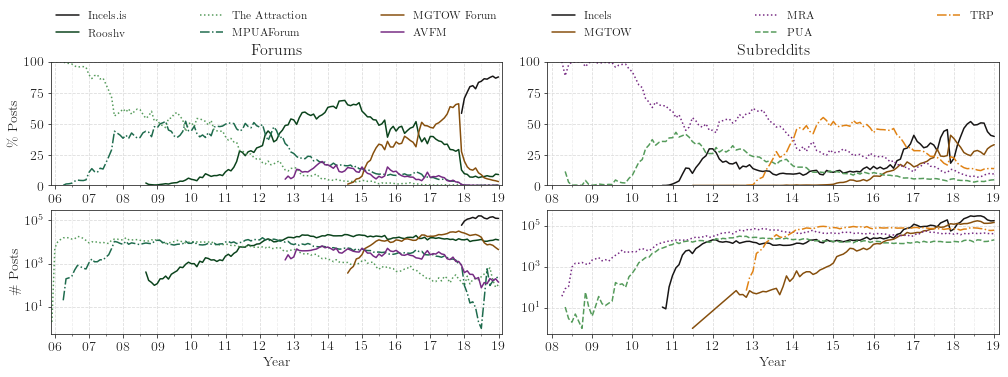

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(14, 5.25), gridspec_kw={"wspace": 0.1})

for total, y_label in zip([True, False], ["\# Posts", "\% Posts"]):
    plot_days_counts(filter_days_all_general, colors_f, ls_f,
                     leg=platform_names[1:], 
                     legend=not total, forums=True, total=total,
                     ylim_norm=[0, 100], yticks_norm=[0, 25, 50, 75, 100], ncols=3,
                     ylabel=y_label, xlabel="", 
                     ax=axs[int(total), 0],
                     helper=helper_filter_days_all_general)

    plot_days_counts(filter_days_all_categories, colors_c, ls_c,
                     leg=[categories_pretty[x] for x in list(categories)],
                     legend= not total, forums=False, total=total, 
                     ylim_norm=[0, 100], yticks_norm=[0, 25, 50, 75, 100], ncols=3, 
                     ylabel="", xlabel="",
                     ax=axs[int(total), 1],
                     helper=helper_filter_days_all_categories)
    
axs[0,0].set_title("Forums")
axs[0,1].set_title("Subreddits")
axs[1,0].set_yscale("log")
axs[1,1].set_yscale("log")
axs[1,0].set_xlabel("Year")
axs[1,1].set_xlabel("Year")

set_size(fig, (14, 5.25))
fig.savefig('/data/savvas/incels/manosphere_analysis/images/gc_posts.pdf', bbox_inches='tight')

# % active users

In [19]:
def get_unique_users_per_day(df, key, freq="M"):
    counts_month = df[[key, 'datetime']].groupby(pd.Grouper(key='datetime', freq=freq))[key].nunique()    
    start_date = '2005-11-21'
    end_date = '2019-01-01'
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    idx = pd.date_range(start_date, end_date, freq=freq)
    counts_month = counts_month.reindex(idx, fill_value=0)
    counts_month.index = pd.DatetimeIndex(counts_month.index)
    counts_month = counts_month.loc[counts_month != 0]
    return counts_month

In [20]:
filter_days_all_unique_users = []
norms_all = []
for i in range(len(dfs)):
    df = dfs[i]
    counts_week = get_unique_users_per_day(dfs[i], 'author')
    counts_per_week = counts_week.values
    weeks = counts_week.index
    filter_days = [(i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_week, weeks)]
    norm = len(set(df['author'].tolist()))
    filter_days_all_unique_users.append(filter_days)
    norms_all.append(norm)

In [21]:
flat_list = [item for sublist in filter_days_all_unique_users[1:] for item in sublist]
df_aux = pd.DataFrame(flat_list, columns=["count", "date"])
helper_filter_days_all_unique_users = dict(df_aux.groupby("date").sum()["count"])

In [22]:
filter_days_all_unique_users_categories = []
norms_all_categories = []
for category in categories:
    df = redditdf[redditdf.subreddit_category==category]
    counts_week = get_unique_users_per_day(df, 'author')
    counts_per_week = counts_week.values
    weeks = counts_week.index
    filter_days = [ (i, j.strftime('%d-%m-%Y')) for (i,j) in zip(counts_per_week, weeks) ]
    norm = len(set(df['author'].tolist()))
    filter_days_all_unique_users_categories.append(filter_days)
    norms_all_categories.append(norm)

In [23]:
flat_list = [item for sublist in filter_days_all_unique_users_categories for item in sublist]
df_aux = pd.DataFrame(flat_list, columns=["count", "date"])
helper_filter_days_all_unique_users_categories = dict(df_aux.groupby("date").sum()["count"])

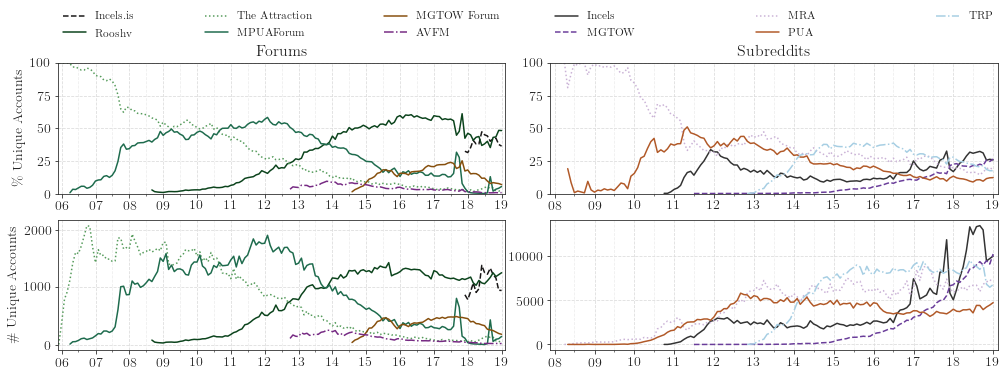

In [24]:
from plot import set_size, plot_days_counts

fig, axs = plt.subplots(2, 2, figsize=(14, 5.25), gridspec_kw={"wspace": 0.1})

for total, y_label in zip([True, False], ["\# Unique Accounts", "\% Unique Accounts"]):
    plot_days_counts(filter_days_all_unique_users, colors_f, ls_f,
                     leg=platform_names[1:], 
                     legend=not total, forums=True, total=total,
                     ylim_norm=[0, 100], yticks_norm=[0, 25, 50, 75, 100], ncols=3, 
                     ylabel=y_label, xlabel="", 
                     ax=axs[int(total), 0],
                     helper=helper_filter_days_all_unique_users)
    
    plot_days_counts(filter_days_all_unique_users_categories, colors_c, ls_c,
                     leg=[categories_pretty[x] for x in list(categories)], 
                     legend=not total, forums=False, total=total,
                     ylim_norm=[0, 100], yticks_norm=[0, 25, 50, 75, 100], ncols=3, 
                     ylabel="", xlabel="", 
                     ax=axs[int(total), 1],
                     helper=helper_filter_days_all_unique_users_categories)

axs[0,0].set_title("Forums")
axs[0,1].set_title("Subreddits")
set_size(fig, (14, 5.25))

fig.savefig('/data/savvas/incels/manosphere_analysis/images/gc_accounts.pdf', bbox_inches='tight')

# Plots Everything altogether

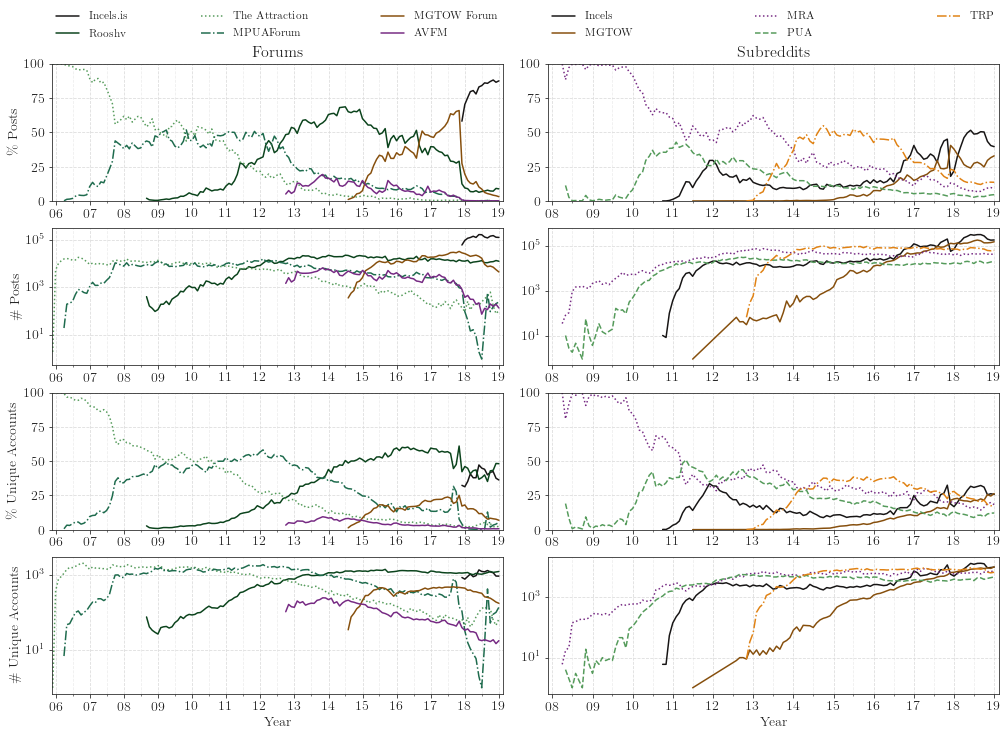

In [39]:
fig, axs = plt.subplots(4, 2, figsize=(14, 10), gridspec_kw={"wspace": 0.1})

for total, y_label in zip([True, False], ["\# Posts", "\% Posts"]):
    plot_days_counts(filter_days_all_general, colors_f, ls_f,
                     leg=platform_names[1:], 
                     legend=not total, forums=True, total=total,
                     ylim_norm=[0, 100], yticks_norm=[0, 25, 50, 75, 100], ncols=3,
                     ylabel=y_label, xlabel="", 
                     ax=axs[int(total), 0],
                     helper=helper_filter_days_all_general)

    plot_days_counts(filter_days_all_categories, colors_c, ls_c,
                     leg=[categories_pretty[x] for x in list(categories)],
                     legend= not total, forums=False, total=total, 
                     ylim_norm=[0, 100], yticks_norm=[0, 25, 50, 75, 100], ncols=3, 
                     ylabel="", xlabel="",
                     ax=axs[int(total), 1],
                     helper=helper_filter_days_all_categories)
    
axs[0,0].set_title("Forums")
axs[0,1].set_title("Subreddits")
axs[1,0].set_yscale("log")
axs[1,1].set_yscale("log")


axs = axs[2:,:]

for total, y_label in zip([True, False], ["\# Unique Accounts", "\% Unique Accounts"]):
    plot_days_counts(filter_days_all_unique_users, colors_f, ls_f,
                     leg=platform_names[1:], 
                     legend=False, forums=True, total=total,
                     ylim_norm=[0, 100], yticks_norm=[0, 25, 50, 75, 100], ncols=3, 
                     ylabel=y_label, xlabel="", 
                     ax=axs[int(total), 0],
                     helper=helper_filter_days_all_unique_users)
    
    plot_days_counts(filter_days_all_unique_users_categories, colors_c, ls_c,
                     leg=[categories_pretty[x] for x in list(categories)], 
                     legend=False, forums=False, total=total,
                     ylim_norm=[0, 100], yticks_norm=[0, 25, 50, 75, 100], ncols=3, 
                     ylabel="", xlabel="", 
                     ax=axs[int(total), 1],
                     helper=helper_filter_days_all_unique_users_categories)
    
axs[1,0].set_yscale("log")
axs[1,1].set_yscale("log")
axs[1,0].set_xlabel("Year")
axs[1,1].set_xlabel("Year")
    
set_size(fig, (14, 10.25))

fig.savefig('/data/savvas/incels/manosphere_analysis/images/all.pdf', bbox_inches='tight')

---